# Applications of Machine Learning to Musicology

Notebook written by Ryan A. Duncan

## Introduction

Music is an interesting application of machine learning due to the rich patterns it exhibits over multiple domains, ranging from the tonal content of a given piece to its temporal structure and style. In this project (or rather, Part 1 of this project, since I plan to keep adding to it) I explore how machine learning methods can be applied to determining the key and mode of a piece from its tonal content. I examine three kinds of classification problems: (1) determining the key signature alone, (2) determining the mode alone, and (3) determining the key (i.e., the key signature and the mode simultaneously). I apply these three classification tasks to data in two different forms: (A) a dataset of musical pieces that have all been transposed to the same key signature, and (B) a dataset of pieces in which all of them have been transposed to all possible key signatures. While I find that classical machine learning methods perform very well for these classification tasks, the mode classification problem in particular varies in complexity based both on whether the key signature is also determined and on whether the task is trained on dataset A or dataset B (i.e., whether it is making a modal determination from data with a given key signature or whether it is trying to determine the mode from data across all key signatures). Furthermore, it is more difficult for a model to perform the mode classification task on dataset B than to perform the key classification task (i.e., classifying both mode and key signature simultaneously) on the same dataset, despite the key classification task being the more complex mapping. As I discuss at the end of this notebook, this reflects how "relative" concepts in functional harmony translate to nonlinearities in a machine learning context.

In [1]:
from music21 import environment, stream, note, meter, key, chord, duration
import pandas as pd
import pickle
import sys
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
sys.path.append('modules')
from music_project import plot_tsne

## Explanation of Musical Terms

Before getting into the details of the dataset and the modelling I first want to briefly review the musical terms relevant to this project. If you are unfamiliar with music theory you can read up on some elementary concepts [here](https://method-behind-the-music.com/theory/).

### Pitches and Pitch Classes

Physically, sound corresponds to the wavelike vibrational modes of an elastic medium. An unbounded continuum admits a continuous range of frequencies for such modes, but in most musical traditions we only consider a discrete subset of these solutions as **pitches**. These pitches are combined coincidentally (denoting **harmony**) and sequentially (denoting **melody**) to construct musical pieces.

The construction of the set of pitch classes for a given musical system begins by choosing a reference frequency, from which all other allowable pitches can be determined. In the western classical tradition this reference is generally taken to be 440 Hz, which defines the note $A4$. The number "4" in the pitch label denotes the octave. If we multply or divide this frequency by a power of 2 we obtain the frequency of other $A$ pitches in different octaves--for example, 880 Hz corresponds to the note $A5$, and 220 Hz corresponds to the note $A3$. Pitches are therefore defined logarithmically in terms of frequency. Within an octave the allowable division of pitches varies widely among different cultures, but in the western classical tradition each octave is divided into increments of 12 called *half-steps*. The set of pitches $p$ in western classical music is therefore given by

$p = 9 + 12 \log_2{\frac{f}{440 \, \textrm{Hz}}}$

where $f$ is the frequency of the note and the 9 is an offset such that the note $C4$ has a value of $p = 0$ (due to historical convention). For this project we will only care about the **pitch classes**, $p_c$, which are given by

$p_c \equiv p\mod12$

and correspond to the pitches subdivided within an octave. The allowed pitch classes in the western classical tradition are given in the following table:



|$p_c$|Class name|
|-----|----------|
|$0$|$C$|
|$1$|$C\sharp$/$D\flat$|
|$2$|$D$|
|$3$|$D\sharp$/$E\flat$|
|$4$|$E$|
|$5$|$F$|
|$6$|$F\sharp$/$G\flat$|
|$7$|$G$|
|$8$|$G\sharp$/$A\flat$|
|$9$|$A$|
|$10$|$A\sharp$/$B\flat$|
|$11$|$B$|



The symbol $\sharp$ is called a **sharp**, and it raises the pitch by 1. Likewise the symbol $\flat$ is called a **flat** and it lowers the pitch by 1. Sharps and flats are collectively called **accidentals**, and a pitch that is neither sharp nor flat is called **natural**. Note that a single pitch class can have two possible names, depending on whether you sharp the note below it or flat the note above it. For our analysis we will ignore such **enharmonic equivalence** and only consider the value of $p_c$. For more information about pitches and pitch classes see [here](https://en.wikipedia.org/wiki/Pitch_class#Other_ways_to_label_pitch_classes).

### Keys, Modes, and Key Signatures

Having defined the allowable pitches within our musical system we now need to develop ways in which these pitches can be combined to produce music. Notions of what pitches "go well" together comprise the concept of **tonality**. One way that tonality is codified in western classical music is by the **key** of a piece, which can be thought of as a definition of what the most important pitches are for that piece among the set of all allowable pitches.

Keys have two main components, the **key signature** and the **mode**. The key signature essentially defines a smaller preferred subclass of pitches, and the mode defines the "home pitch", also called the **tonic**, of the piece given its key signature. The two most common modes in western music are **major** and **minor**, which respectively have the effect of making the piece sound "happy" or "sad." The mode has a strong impact on the overal effect of a piece, while the effect of the key signature is much more subtle. While most people can't necessarily identify the key signature of a piece that they are listening to, with a bit of musical training they will likely be able to identify its mode. For "functional" music such as religious hymns the key signature matters very little, and is changed as needed to accomodate the vocal range of the singers.

### Scales and Tonic Triads

The "special" notes picked out by the choice of key, in order of increasing pitch and starting from the tonic, are called the **scale** of the key. The position of a pitch in the scale of the key is called its **scale degree**. The simplest of all major keys corresponds to a scale featuring only the natural pitches $A$ - $G$, beginning with the note $C$. This is the scale for the key of $C$-major, which can be written in musical notation as:

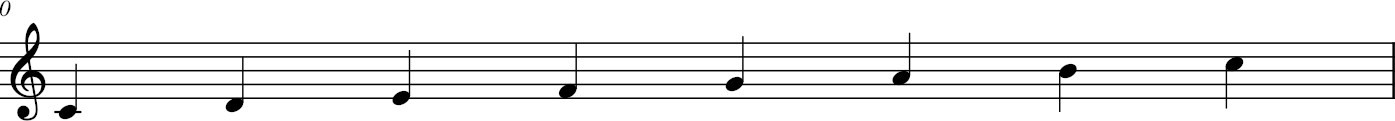

In [2]:
env = environment.Environment()    
env['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'
meas = stream.Measure()
tsig = meter.TimeSignature(None)
tsig.style.hideObjectOnPrint = True
meas.append(tsig)
for l in ['c4','d4','e4','f4','g4','a4','b4','c5']:
    n = note.Note(l)
    meas.append(n)
meas.show()

(for a primer on music notation see [here](https://method-behind-the-music.com/theory/notation/)). The minor key corresponding to this key signature is $A$-minor, which has the note $A$ as its tonic and its scale given by:

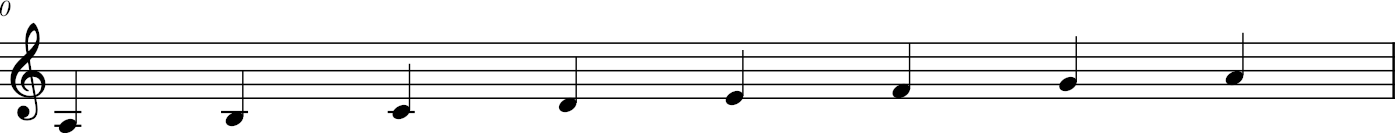

In [3]:
meas = stream.Measure()
tsig = meter.TimeSignature(None)
tsig.style.hideObjectOnPrint = True
meas.append(tsig)
for l in ['a3','b3','c4','d4','e4','f4','g4','a4']:
    n = note.Note(l)
    meas.append(n)
meas.show()

Two keys belonging to the same key signature with different modes are said to be *relative*
 to each other--i.e., $C$-major is the **relative major** of $A$-minor, and $A$-minor is the **relative minor** of $C$-major. Note that relative keys share a common set of pitches in their scale.

We can change the key signature to denote new keys corresponding to major and minor scales with different tonics. For example, consider the key of E-major, whose scale is given by:

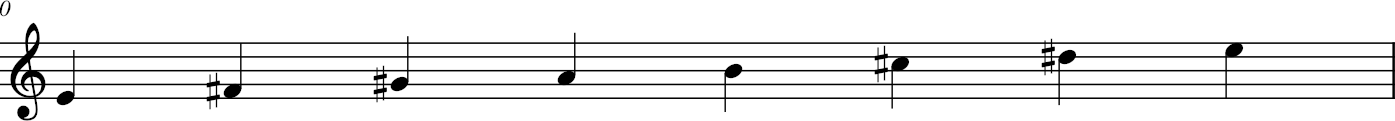

In [4]:
meas = stream.Measure()
tsig = meter.TimeSignature(None)
tsig.style.hideObjectOnPrint = True
meas.append(tsig)
for l in ['e4','f#4','g#4','a4','b4','c#5','d#5','e5']:
    n = note.Note(l)
    meas.append(n)
meas.show()

The relative minor of $E$-major is $C\sharp$-minor, whose scale is given by:

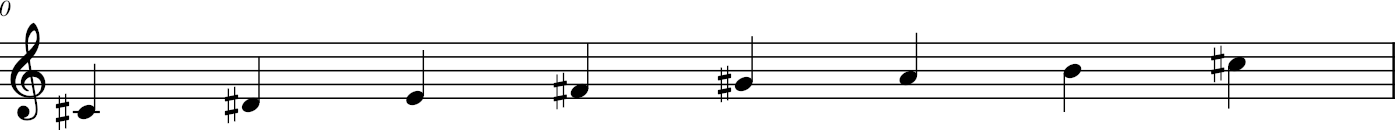

In [5]:
meas = stream.Measure()
tsig = meter.TimeSignature(None)
tsig.style.hideObjectOnPrint = True
meas.append(tsig)
for l in ['c#4','d#4','e4','f#4','g#4','a4','b4','c#5']:
    n = note.Note(l)
    meas.append(n)
meas.show()

The pitches in the scale of any key can be generated from those for any other key according to the following equation:

$p_{c,new}^{(i)} = (p_{c}^{(i)} + k)\mod12, \quad p_c^{(i)} \in S$

Where $S$ is the set of pitches in a valid scale and $k$ is a constant. In particular, $S$ can be the set of natural pitches. A transformation of this form is called a **transposition**.

When several notes are played together at the same time they form a **chord**. The most important chord for a given key is its **tonic triad**, which is a chord featuring three notes: (1) the tonic, (2) the 3rd scale degree, and (3) the 5th scale degree. This chord defines the harmonic "home" of the piece, and the notes in this chord will be especially highly represented in its overall tonal content. The tonic triads for $C$-major, $A$-minor, $E$-major, and $C\sharp$-minor are shown below:

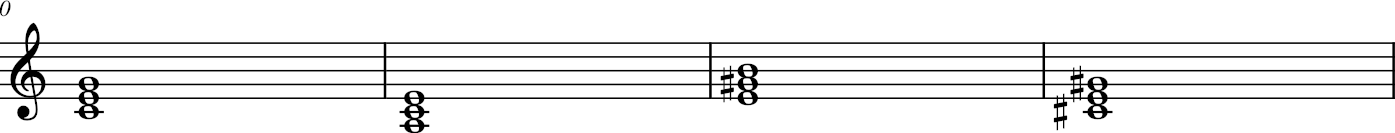

In [6]:
st = stream.Stream()
dur = duration.Duration(4)
meas1 = stream.Measure()
meas1.append(chord.Chord(['c4', 'e4', 'g4'], duration=dur))

meas2 = stream.Measure()
meas2.append(chord.Chord(['a3', 'c4', 'e4'], duration=dur))

meas3 = stream.Measure()
meas3.append(chord.Chord(['e4', 'g#4', 'b4'], duration=dur))

meas4 = stream.Measure()
meas4.append(chord.Chord(['c#4', 'e4', 'g#4'], duration=dur))

st.append([meas1, meas2, meas3, meas4])
st.show()

## MIDI Hymns Dataset

Notions of tonality in western classical music have varied over the centuries, and much music written since the 19th century especially has challenged many of the principles of standard functional harmonic theory. To keep things simple as we start out I decided to begin my analysis by first considering a dataset of christian hymns. Hymns are musically quite simple and generally adhere very well to the standard rules of functional harmony. Additionally, the key of a given hymn is often arbitrary and decided by convenience, and thus does not reflect any underlying artistic design. This means that we can feature engineer by transposing each hymn to the 11 other key signatures, leading to a much larger dataset. This feature engineering would not be justifiable when considering major pieces in the classical canon, since composers generally do employ their artistic judgement when choosing a specific key for a given piece.

The data analyzed in this project are a collection of 362 hymns in MIDI file format. We need to develop a feature vector $\mathbf{x}$ from the content of these files that can be used to classify the pieces according to the tonal characteristics that we are interested in. One restriction on $\mathbf{x}$ is that it should be scale-invariant (a short hymn in $G$-major is just as "$G$-major" as a long hymn in $G$-major). We can achieve this with the following defintion:

$x_m^{(n)} = \frac{\sum_{j \in N_n}I[p_c(j) = m]D_j}{\sum_{j \in N_n}D_j}, \quad $

where $n$ is the hymn index, $m$ is a pitch class index, $N_n$ is the set of all notes in the $n$th hymn, $I[p_c(j) = m]$ is an indicator variable equal to 1 if the pitch class of the $j$th note $p_c(j)$ is equal to $m$ and 0 otherwise, and $D_j$ is the duration of the $j$th note in $N_n$. $x_m^{(n)}$ can be thought of as the relative tonal weight of pitch class $m$ in hymn $n$. From the definition we see that $\sum_m x_m^{(n)} = 1$, and thus the $\mathbf{x}^{(n)}$ are unit vectors in a 12-dimensional space with a Manhattan distance metric. Evidently $\mathbf{x}^{(n)}$ is scale-invariant, since scaling the piece (e.g., repeating the hymn a given number of times) increases both the numerator and the denominator in the above definition by the same factor.

One thing to note here is that the normalization property imposes a constraint on the vectors $\mathbf{x}^{(n)}$, which reduces the number of degrees of freedom in the dataset by 1. In other words, if any 11 of the elements in $\mathbf{x}^{(n)}$ are known then the 12th one is also known exactly since all elements must together sum to 1. To account for this collinearity in the 12-dimensional representation we will therefore drop the last element of $\mathbf{x}^{(n)}$ and only use the first 11 elements when modeling.

Using the MIDI parsing capabilities of the `music21` library we can construct the 11-dimensional $\mathbf{x}^{(n)}$ vectors for each hymn in the dataset and generate the feature matrix $\mathbf{X}$, where $X_{nm} = x_m^{(n)}$. Each hymn is given a set of 3 class labels, corresponding to its key signature (`sig`), mode (`mode`), and key (`key`). The labels for the key and the mode will simply be the names of each (e.g. "major" for mode, "$C$ major" for key). We will label the key signature according to the pitch class of the major tonic (e.g., the label of the key signature for the keys of both $C$-major and $A$-minor will be 0, the pitch class of $C$).

Below are some tables summarizing the dataset according to key and mode:

In [7]:
dic_mode = {n:'major' if n == 1 else 'minor' for n in range(2)}

dic_key = {}
dic_key[0] = 'A minor'
dic_key[1] = 'C major'
dic_key[2] = 'B-flat minor'
dic_key[3] = 'D-flat major'
dic_key[4] = 'B minor'
dic_key[5] = 'D major'
dic_key[6] = 'C-flat minor'
dic_key[7] = 'E-flat major'
dic_key[8] = 'C-sharp minor'
dic_key[9] = 'E major'
dic_key[10] = 'D minor'
dic_key[11] = 'F major'
dic_key[12] = 'D-sharp minor'
dic_key[13] = 'F-sharp major'
dic_key[14] = 'E minor'
dic_key[15] = 'G major'
dic_key[16] = 'F minor'
dic_key[17] = 'A-flat major'
dic_key[18] = 'F-sharp minor'
dic_key[19] = 'A major'
dic_key[20] = 'G minor'
dic_key[21] = 'B-flat major'
dic_key[22] = 'G-sharp minor'
dic_key[23] = 'B major'

df = pd.read_csv('csv/hymns_single-tone_notranspositions_nosampling.csv', index_col=0).rename(columns={'sig-mode':'key'})
df.groupby('key', as_index=False).agg(counts=('name', 'count')).apply(lambda x: pd.Series([dic_key[x['key']], x['counts']]), axis=1).rename(columns={0:'key', 1:'counts'}).set_index('key')


,counts
key,
A minor,2
C major,25
D-flat major,8
D major,26
E-flat major,56
D minor,5
F major,74
E minor,3
G major,56


In [8]:

df.groupby('mode', as_index=False).agg(counts=('name', 'count')).apply(lambda x: pd.Series([dic_mode[x['mode']], x['counts']]), axis=1).rename(columns={0:'mode', 1:'counts'}).set_index('mode')

,counts
mode,
minor,14
major,348


One thing we notice is that there are very few minor hymns compared to major ones in the dataset. We will have to upsample minor hymns before we train any mode-detecting models to account for this. We also notice that not all 24 keys are represented in the dataset, and that the counts vary significantly among the different keys that are present. This will end up not being a huge problem for us, since as I mentioned above we can freely transpose the hymns to get an equal representation for each key.

## Data Exploration

### Exploring the non-transposed dataset

Before we augment the dataset by applying transpositions and sampling let's first explore the dataset as-is with unsupervised methods. The "analyzer" objects loaded below contain a suite of unsupervised models, and were constructed using the `music_project` module in `./modules/` and the `sklearn` library.

In [9]:
with open('models/part_1_hymns/analyzer_sig-mode_notrans_nosamp.pkl', 'rb') as f:
    ana_key = pickle.load(f)
    
with open('models/part_1_hymns/analyzer_sig_notrans_nosamp.pkl', 'rb') as f:
    ana_sig = pickle.load(f)
    
with open('models/part_1_hymns/analyzer_mode_notrans_nosamp.pkl', 'rb') as f:
    ana_mode = pickle.load(f)

Below is a t-distributed Stochastic Neighbor Embedding (t-SNE) of the feature matrix $\mathbf{X}$. t-SNE is a nonlinear feature mapping designed to project high-dimensional data onto a low-dimensional space for easier visualization and interpretation, while preserving a general sense of proximity between points. The same embedding is shown in all three figures below, with colors denoting the key signature, mode, and key. From the first figure we see that the data largely falls into well-separated blobs of mostly a single key signature for the key signatures that are well-represented. Since there are so few minor hymns in the dataset, spread out across different minor keys, there aren't any well-defined blobs of minor data points evident in the second figure. However, we do notice that in several cases the minor data points lie on the periphery of the blobs corresponding to their key signatrue, indicating that for a given key signature the mode is indeed differentiable to a certain degree.

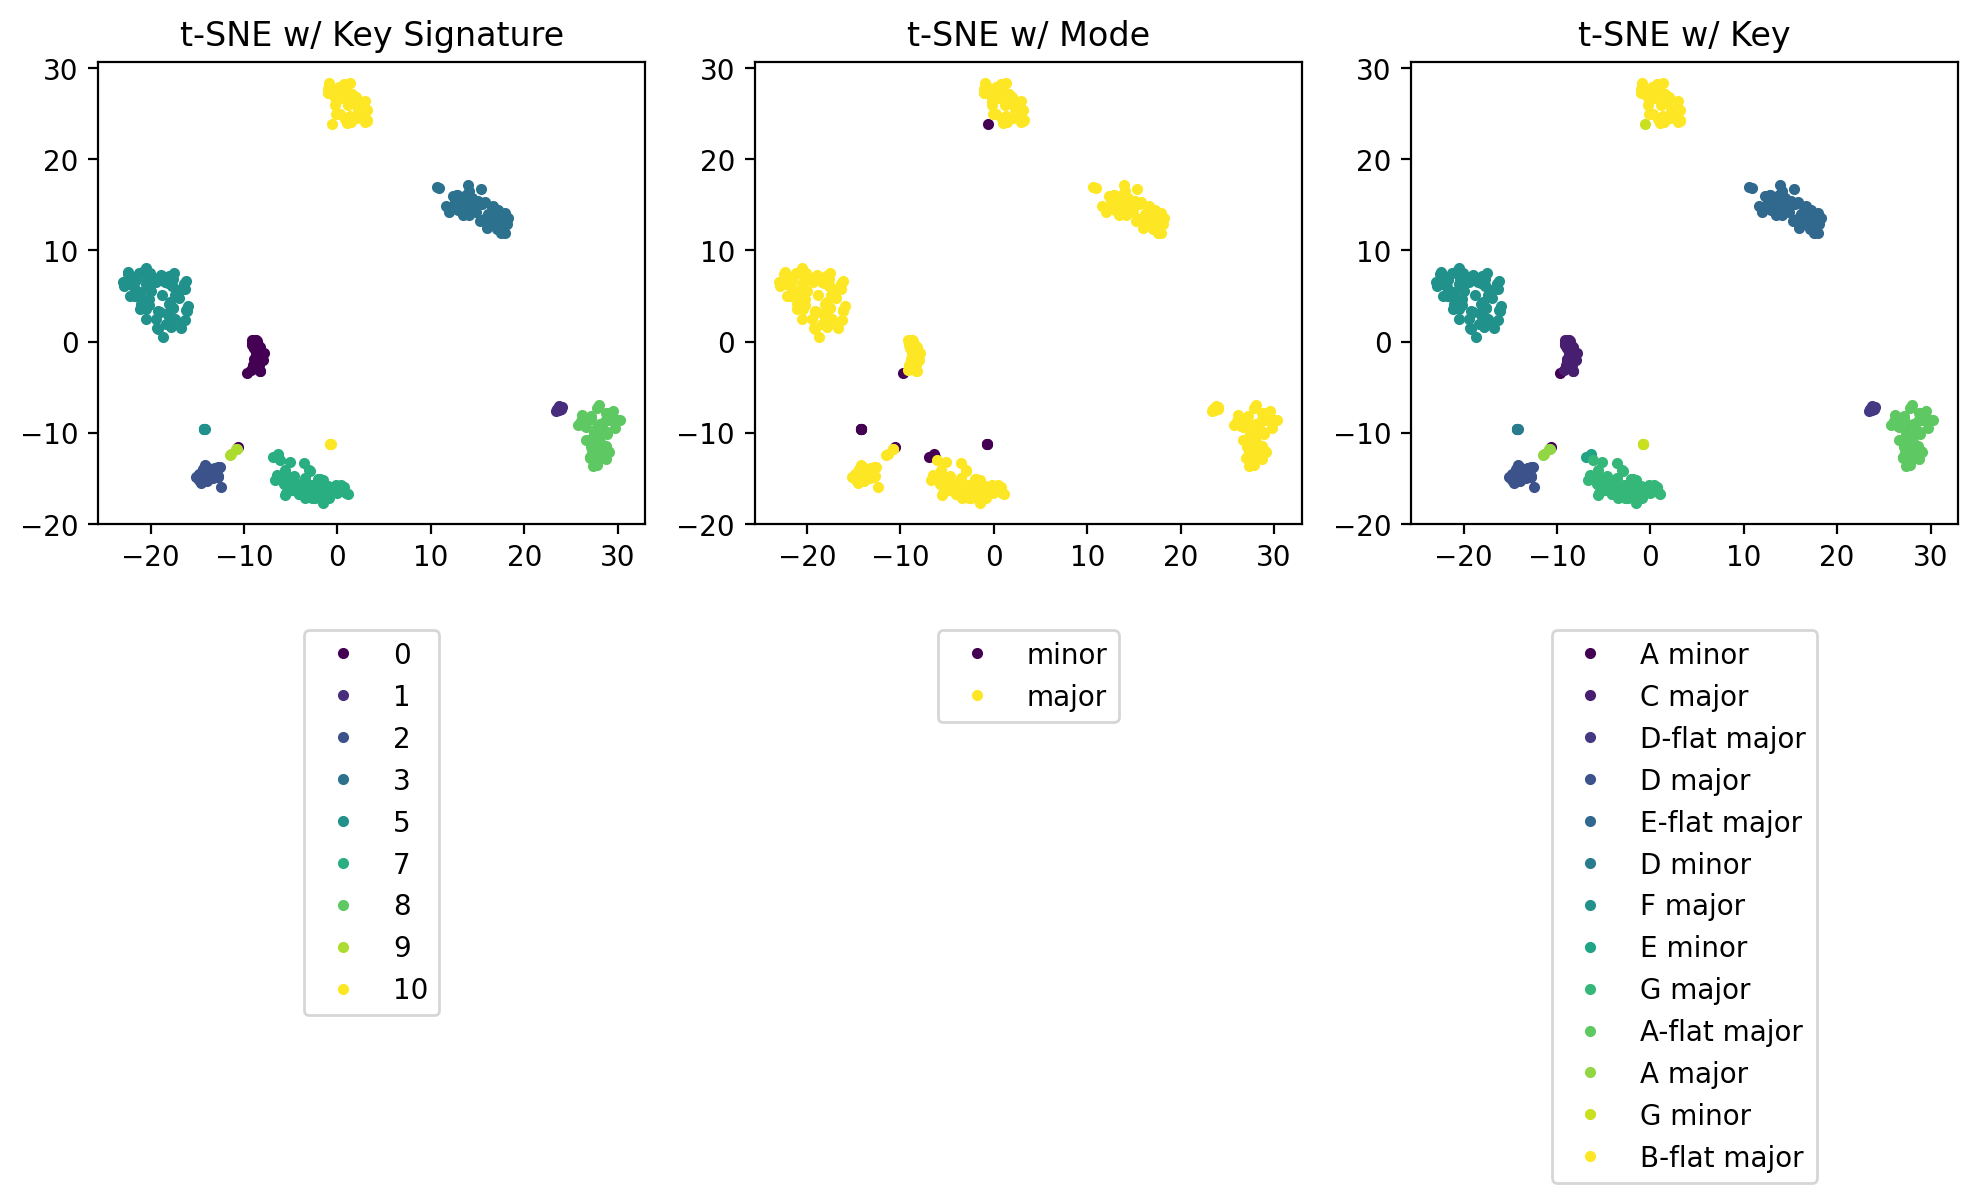

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
anas = [ana_sig, ana_mode, ana_key]
dics = [None, dic_mode, dic_key]
for i,ana in enumerate(anas):
    ax = axs[i]
    Xe = ana.get_embedding('tsne')
    y = ana.y
    plot_tsne(ax, Xe, y, legend_dict=dics[i], markersize=3)

axs[0].set_title('t-SNE w/ Key Signature')
axs[1].set_title('t-SNE w/ Mode')
axs[2].set_title('t-SNE w/ Key')
plt.show()

Embeddings of this form are useful to get general ideas of the proximity between data points in high-dimensions, but the dimension reduction procedure for t-SNE is very opaque and much information regarding the structure of the data in the high-dimensional space is lost. Therefore it is useful to perform clustering analysis in the high dimensional space to get a sense of this structure. Below are t-SNE plots comparing the ground truth key labels with cluster assignments produced by the DBSCAN clustering algorithm. We see that DBSCAN generally reproduces a clustering scheme that is close to the ground truth. This indicates that the 11D structure of the data does indeed reflect the tonal character of the pieces in the dataset to some degree.

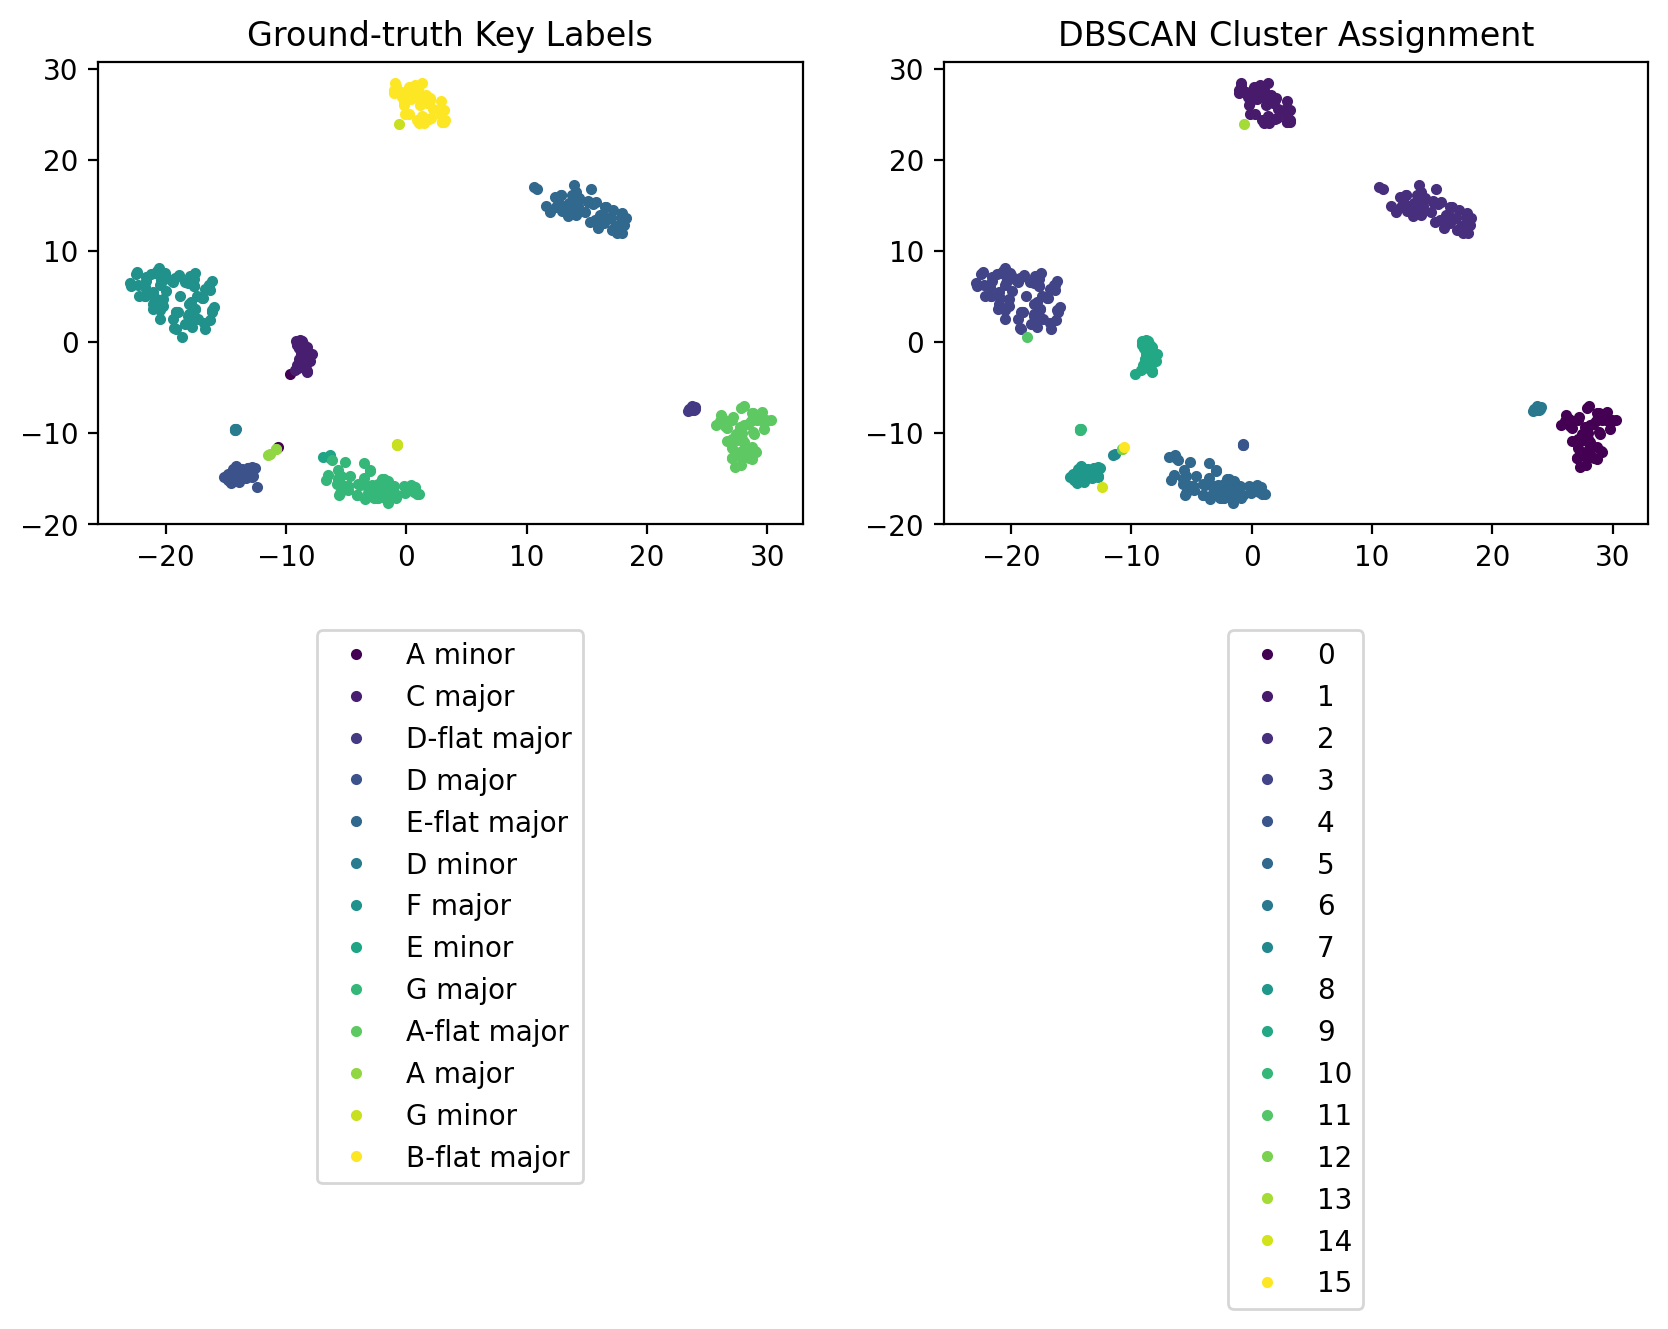

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
Xe = ana_key.get_embedding('tsne')
y = ana_key.y
plot_tsne(axs[0], Xe, y, legend_dict=dic_key)
axs[0].set_title('Ground-truth Key Labels')

lab = ana_key.clusterings['dbscan'].labels_
plot_tsne(axs[1], Xe, lab)
axs[1].set_title('DBSCAN Cluster Assignment')
plt.show()

### Transposing all hymns to the same key signature

As mentioned above, for hymns the key signature is usually arbitrarily chosen. As such, we can compare all of the hymns in our dataset on an equal footing if we transpose all of them to the same key signature, which we will take to be 0 (i.e., where all major hymns are transposed to $C$-major and all minor ones are transposed to $A$-minor). Let's load in the analyzer object for this transformed dataset:

In [12]:
with open('models/part_1_hymns/analyzer_mode_trans-to-0_nosamp.pkl', 'rb') as f:
    ana_tt0 = pickle.load(f)

Now lets plot the t-SNE embedding for this dataset and compare the ground-truth mode labels with DBSCAN cluster designations:

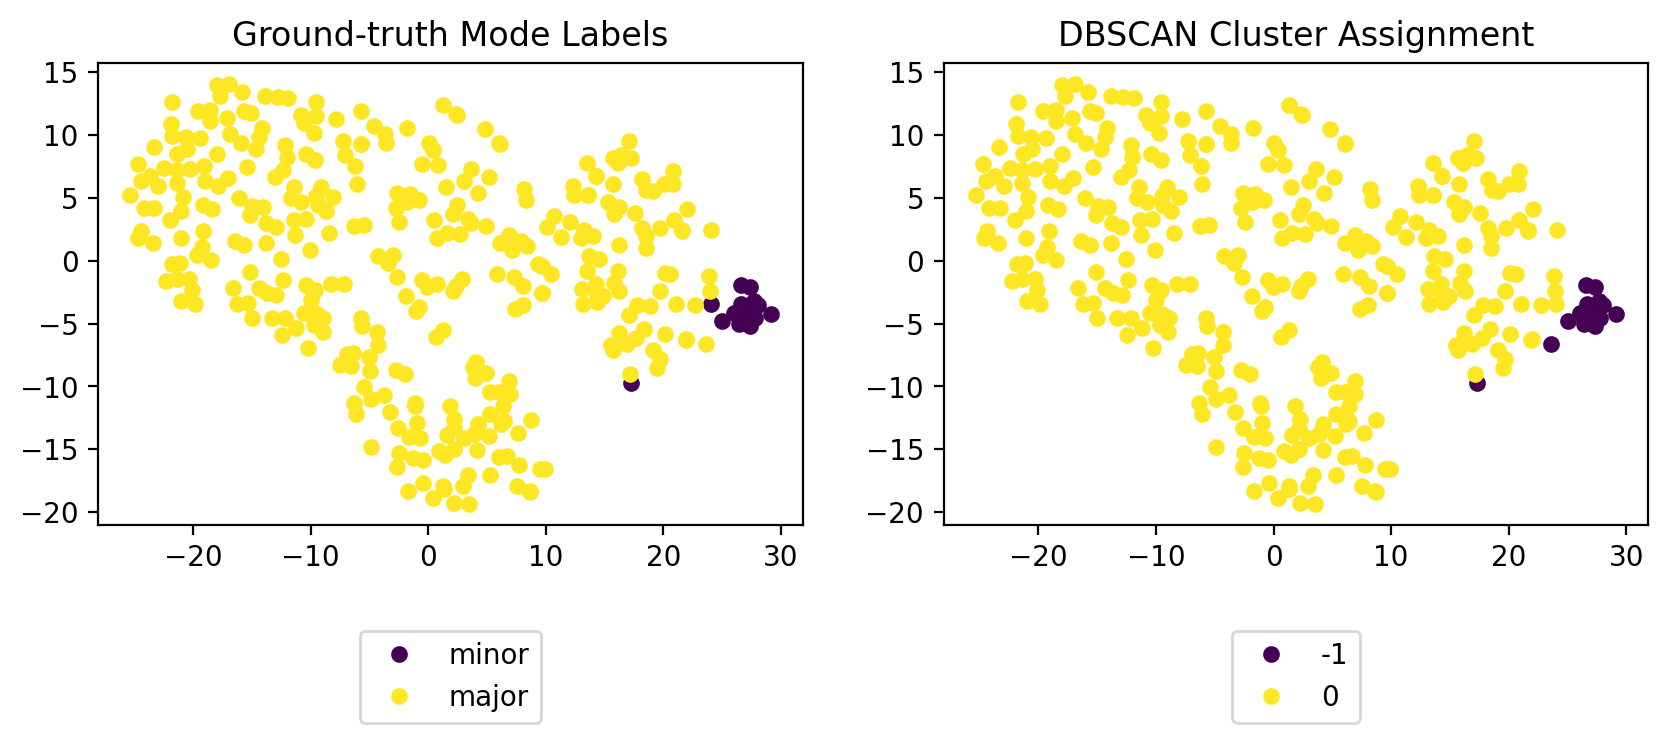

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
Xe = ana_tt0.get_embedding('tsne')
y = ana_tt0.y
plot_tsne(axs[0], Xe, y, legend_dict=dic_mode, markersize=5)
axs[0].set_title('Ground-truth Mode Labels')

lab = ana_tt0.clusterings['dbscan'].labels_
plot_tsne(axs[1], Xe, lab, markersize=5)
axs[1].set_title('DBSCAN Cluster Assignment')
plt.show()

From the plot it appears that DBSCAN has reproduced the clustering between major and minor modes quite well. However, we see that the label for one of the "clusters" in the DBSCAN plot (the one mostly corresponding to minor hymns) is -1, which is how `sklearn`'s DBSCAN implementation designates "noise" points (i.e., points that are not in the "neighborhood" of a "core" cluster point). We are therefore getting somewhat mixed signals from t-SNE and DBSCAN. On one hand these points are close to each other in the t-SNE embedding, which tries to preserve the same proximity characteristics of the high-dimensional representation of the data. On the other hand, DBSCAN did not naturally group these points together, and instead chose to have them all stand individually as "noise." Thus, it is still somewhat unclear how the structure of the data aligns with the modal characteristics of the pieces in the dataset. In particular we don't yet know whether minor pieces form a natural grouping in the 11D representation--they are certainly differentiated from the major hymns, but it is unclear how systematically. We will get an answer to this question later in the notebook when we apply supervised learning methods.

Given that we have transposed all pieces to the same key signature, it is now instructive to look at the average values of the features $x_m^{(n)}$ for the two modes. Let's load in the data and plot these:

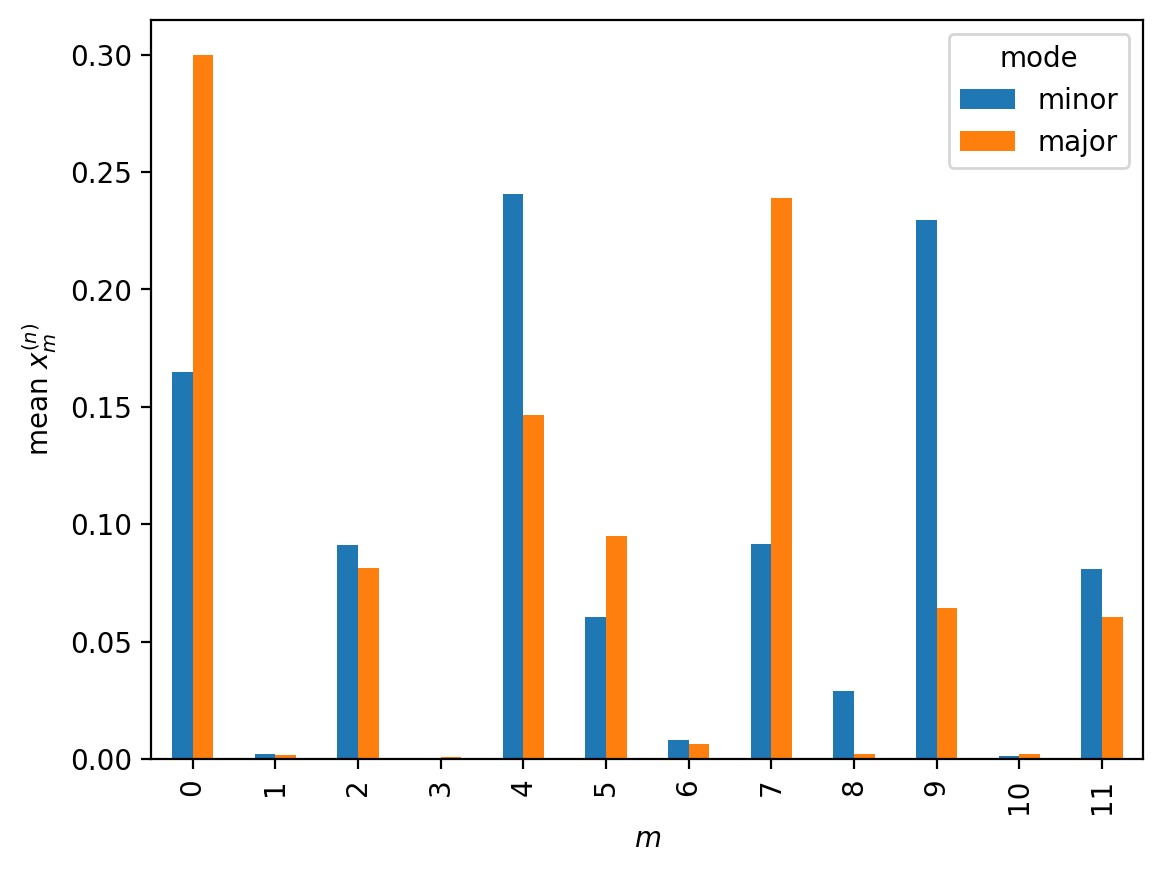

In [14]:
df = pd.read_csv('csv/hymns_single-tone_tt0_nosampling.csv', index_col=0)
df.groupby('mode')[[str(n) for n in range(12)]].mean().rename(index={0:'minor', 1:'major'}).T.plot(kind='bar', xlabel='$m$', ylabel='mean $x_m^{(n)}$')
plt.show()

We see that for both modes the most highly represented pitches are the natural pitches 0 ($C$), 2 ($D$), 4 ($E$), 5 ($F$), 7 ($G$), 9 ($A$), and 11 ($B$). This makes sense, since in the key signature 0 the scale is comprised of all natural pitches. For both the minor and major modes we see that the three most important pitch classes in each case are those in the tonic triads (0, 4, 7 for major and 9, 0, 4 for minor), which jibes with our discussion above about harmony and chords. For the major mode we see that the most important pitch is the tonic 0, but interestingly for the minor mode the most important pitch is not the tonic 9 but rather the **dominant** 4. The dominant, or 5th scale degree, is the second most important pitch in a given key, and is the root of the dominant triad which is the second most important chord in the harmonic space of a given key. The dominant pitch interestingly shows up in both the tonic and dominant triads, while the tonic pitch only shows up in the tonic triad. Given this, it is not particularly surprising that the dominant pitich might actually outcompete the tonic, since it gets counts from both tonic and dominant harmonies.



### Transposing all hymns to all key signatures

As a final exploratory exercise before we move on to the classification tasks, let us now consider what happens when we transpose all of the hymns to all possible key signatures. Below we load in the analyzer objects with the models for this:

In [15]:
with open('models/part_1_hymns/analyzer_sig-mode_alltrans_nosamp.pkl', 'rb') as f:
    ana_key = pickle.load(f)
    
with open('models/part_1_hymns/analyzer_sig_alltrans_nosamp.pkl', 'rb') as f:
    ana_sig = pickle.load(f)
    
with open('models/part_1_hymns/analyzer_mode_alltrans_nosamp.pkl', 'rb') as f:
    ana_mode = pickle.load(f)

Below is the t-SNE mapping of the transposed dataset, which consists of 12 blob-like features similar in shape to the t-SNE mapping of the previous single-key-signature dataset. The similar appearance of all of these blob features is no accident, and arises because the transposition augmentation that we performed imposes a high degree of symmetry on the dataset. The transposition transformation is equivalent to a rotation in feature space, and following our mass-transposition procedure the entire dataset is now invariant under a set of 12 new rotations. This rotational symmetry of our dataset is qualitatively (yet not exactly) preserved in the t-SNE embedding as well to yield clusters that also appear to be rotated relative to each other in the embedded space.

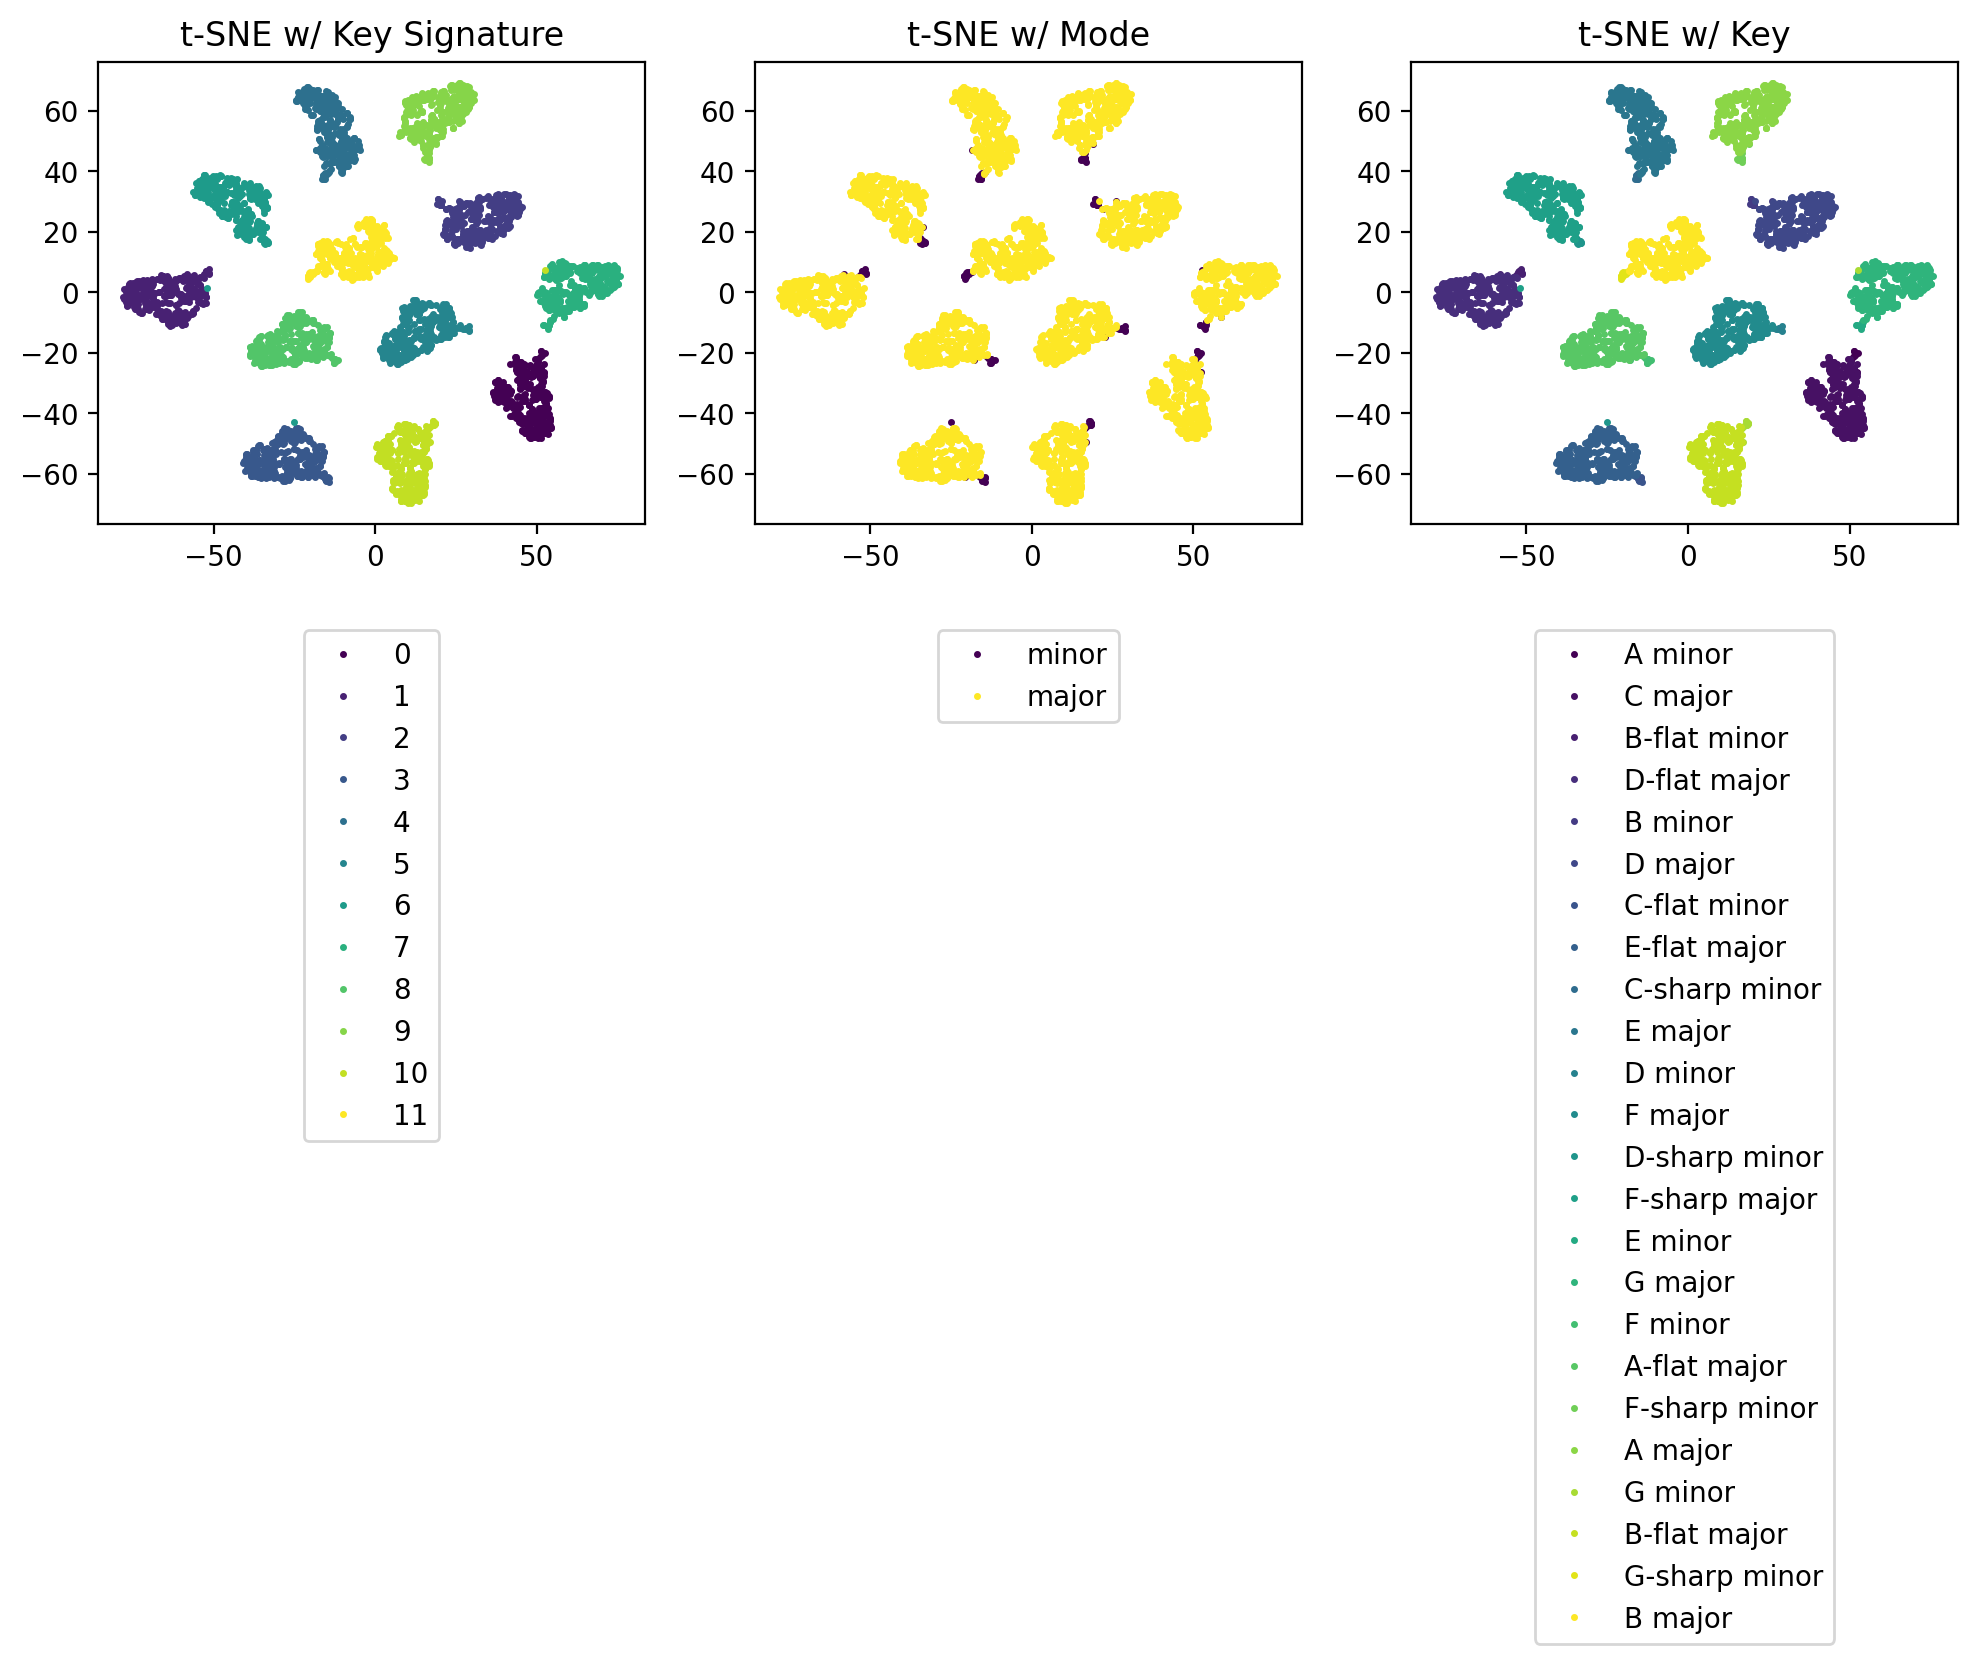

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
anas = [ana_sig, ana_mode, ana_key]
dics = [None, dic_mode, dic_key]
for i,ana in enumerate(anas):
    ax = axs[i]
    Xe = ana.get_embedding('tsne')
    y = ana.y
    plot_tsne(ax, Xe, y, legend_dict=dics[i], markersize=1.5)

axs[0].set_title('t-SNE w/ Key Signature')
axs[1].set_title('t-SNE w/ Mode')
axs[2].set_title('t-SNE w/ Key')
plt.show()

All of the different key signature blobs appear to be very well separable, meaning that an appropriate machine learning classifier should be able to determine key signature with very high accuracy. Let's look at how clustering performs on the mass-transposed dataset:

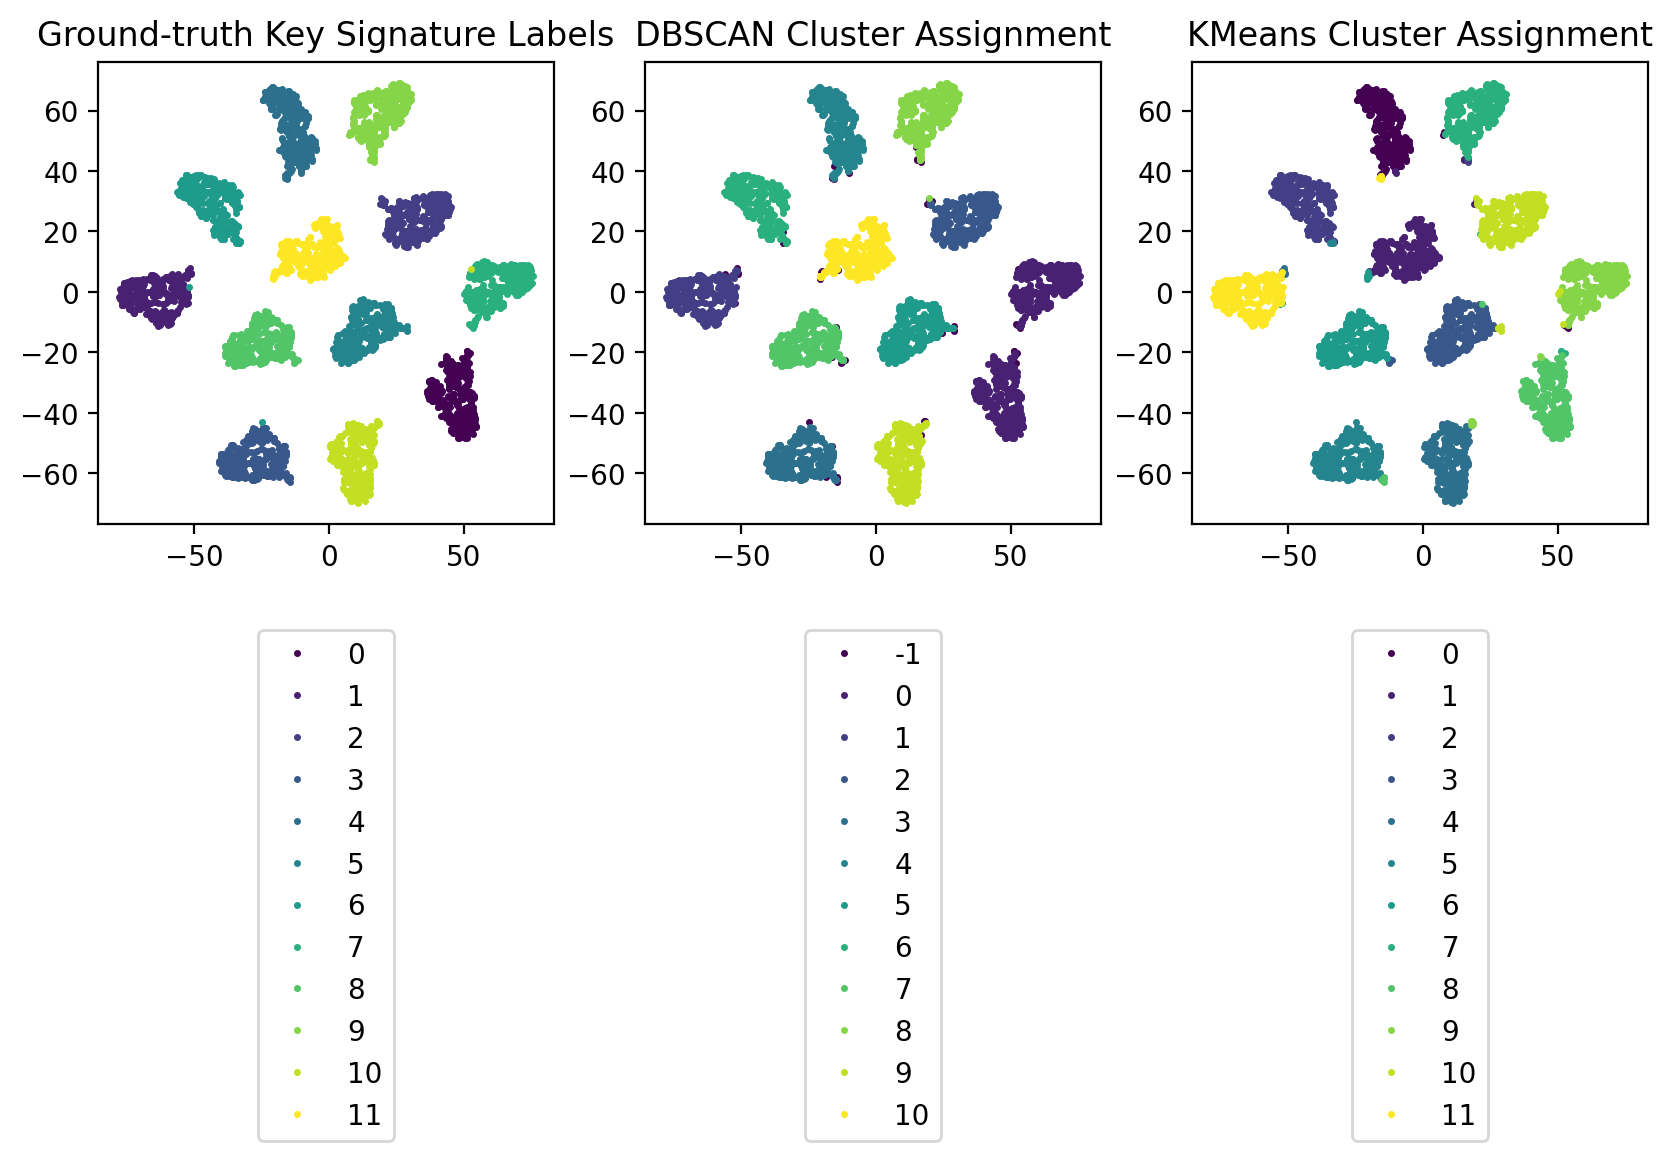

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
Xe = ana_sig.get_embedding('tsne')
y = ana_sig.y
plot_tsne(axs[0], Xe, y, markersize=1.5)
axs[0].set_title('Ground-truth Key Signature Labels')

lab = ana_sig.clusterings['dbscan'].labels_
plot_tsne(axs[1], Xe, lab, markersize=1.5)
axs[1].set_title('DBSCAN Cluster Assignment')

lab = ana_sig.clusterings['kmeans'].labels_
plot_tsne(axs[2], Xe, lab, markersize=1.5)
axs[2].set_title('KMeans Cluster Assignment')
plt.show()

Unsurprisingly, DBSCAN is able to recognize the obvious cluster features that we can see by eye in the t-SNE embedding. In fact, even the less sophisticated KMeans algorithm is able to identify the clusters almost perfectly. Note that these clustering algorithms still seem to have trouble with minor hymns, with DBSCAN still classifying them as noise. This may be due to how underrepresented minor hymns are in our dataset. When we use supervised methods for classification we will upsample the minor hymns to account for this.

## Classification

We are now finally in a position to begin training our classification algorithms. We will consider the following classification methods:

- **Logistic Regression**: We will use the elastic-net penalty (linear combinations of L1 and L2 regularization) and will cross-validate over the regularization parmeter and the L1 ratio.

- **Support Vector Classifier (SVC)**: a kernel-based large-margin classifier (i.e., tries to maximize the overall distance between the decision boundary and the data). SVCs can expressively introduce nonlinearities to a model through a proper choice of kernel while maintaining a convex loss function, allowing for relatively fast learning for a nonlinear model. We will use two different kinds SVCs for our analysis:
    - **SVC with radial-basis kernel**, cross validating over the regularization parameter.
    - **SVC with polynomial kernels of degree 1-5**, cross-validating over the regularization parameter and the constant coefficient in the polynomial kernel. These models will help us evaluate the degree of nonlinearity needed for the model to perform well on our classification tasks.
    
- **Decision Trees**: we will use two kinds of individual trees, as well as two different tree-based ensemble methods:
    - **"Pre-pruned" individual tree**: we will train a decision tree using cross-validation over the split criterion, maximum tree depth, and minimum samples per leaf and split. This corresponds to an "early-stopping" training method.
    - **"Post-pruned" individual tree**: we will also train a decision tree using the minimum cost-complexity method, where a tree is first trained to maximum depth and then compared to all sub-trees generated by "pruning back" along the minimum cost-complexity path.
    - **Random Forests**: an ensemble of decision trees are trained in parallel on bootstrapped samples of the dataset, considering only a random subset of the features for each split decision. The classification is then the majority vote of the ensemble. The two degrees of randomness in this method uncorrelate the trees and in principle allow for a reduction in error proportional to the number of trees in the forest. We will cross-validate over the number of trees and the size of the random subset of features per split.
    - **Gradient Boosting**: An ensemble method in which a sequence of decision trees are trained on the residuals of their predecessors, and the final prediction is made based on a linear combination of the output of each tree in the sequence. We will cross-validate over the learning rate (scaling factor for each subsequent tree's contribution), number of trees in the sequence, the fraction of samples randomly chosen to fit each tree, and the number of randomly chosen features considered at each split.

### Mode classification on dataset A

Let's start by considering the dataset of all hymns transposed to key signature 0. As mentioned before, we have to upsample the minor hymns before we try to make any predictions. Having done this our dataset now looks as follows:

In [18]:
df = pd.read_csv('csv/hymns_single-tone_tt0_minor-upsampled.csv', index_col=0)
df['mode'].value_counts().to_frame().rename(index={0:'minor', 1:'major'})

,count
mode,
major,348
minor,348


We now see that we have an equal number of major and minor hymns in our dataset, with 696 total entries. We will refer to this upsampled dataset of all hymns with key signature 0 as **dataset A**. We'll load the analyzer class that contain the models trained on this upsampled data:

In [19]:
with open('models/part_1_hymns/analyzer_mode_trans-to-0_samp.pkl', 'rb') as f:
    ana_tt0 = pickle.load(f)

Below is a table of each of the models along with their training and test accuracies on dataset A:

In [20]:
name_dict = {}
name_dict['logreg'] = 'Logistic Regression'
name_dict['svc-rbf'] = 'SVC RBF'
for n in range(1,6):
    name_dict[f'svc-poly-{n}'] = f'SVC Polynomial {n} degree'
name_dict['dt-gscv'] = 'Pre-pruned Decision Tree'
name_dict['dt-ccp'] = 'Post-pruned Decision Tree'
name_dict['rf'] = 'Random Forest'
name_dict['gradboost'] = 'Gradient Boosting'
name_dict['proj'] = 'Projection'

df_dict = {}
index = [name_dict[name] for name in ana_tt0.models.keys()]
df_dict[('Mode', 'Training accuracy')] = [round(ana_tt0.training_score(name), 2) for name in ana_tt0.models.keys()]
df_dict[('Mode', 'Test accuracy')] = [round(ana_tt0.test_score(name), 2) for name in ana_tt0.models.keys()]

pd.DataFrame(df_dict, index=index)

Mode              
                          Training accuracy Test accuracy
Logistic Regression                    1.00          1.00
SVC RBF                                1.00          1.00
SVC Polynomial 1 degree                1.00          1.00
SVC Polynomial 2 degree                1.00          1.00
SVC Polynomial 3 degree                1.00          1.00
SVC Polynomial 4 degree                1.00          1.00
SVC Polynomial 5 degree                1.00          1.00
Pre-pruned Decision Tree               1.00          1.00
Post-pruned Decision Tree              1.00          1.00
Random Forest                          1.00          1.00
Gradient Boosting                      1.00          1.00
Projection                             0.96          0.99

In addition to the models discussed at the beginning of this section we have also considered a "projection" method, where classification is determined by the maximum of the projection of a data point onto the average feature vector of the various classes. This crude linear method gives us a benchmark against which to compare the other methods we'll use.

We see that every model considered, even the linear ones (Logstic Regression, SVC Polynomial 1 degree) are able to classify the mode with perfect test accuracy, while the Projection method is also near-perfect despite its crudeness. If you recall from the data exploration section above, the t-SNE plots for this dataset seemed to have the minor modes all on one side of the blob but the clustering algorithm failed to put them all into a common cluster. This made it ambiguous as to whether there was a natural grouping of the minor hymns together. Given that linear models are able to perfectly classify minor and major hymns we can conclude that this apparent modal polarization in the t-SNE map does indeed represent a modal polarization in the 11D space as well, since linear models can only classify well if such a polarization exists in the feature space.

### Key Signature, Mode, and Key classification on dataset B

Let's now consider the dataset with two augmentations performed: first we upsample the minor hymns for equal modal representation, and then we transpose all hymns to all key signatures. We will refer to this dataset as **dataset B**. (As an aside, note that since we randomly upsample the minor hymns *before* applying the transpositions, dataset B exhibits the same 12-fold rotational symmetry as the unsampled transposed dataset discussed in the previous section--if these augmentations were performed in the opposite order then this symmetry would be broken). Let's load the dataset:

In [21]:
df = pd.read_csv('csv/hymns_single-tone_alltranspositions_minor-upsampled.csv', index_col=0).rename(columns={'sig-mode':'key'})
df['key'].value_counts().to_frame().sort_index().rename(index=dic_key)

,count
key,
A minor,348
C major,348
B-flat minor,348
D-flat major,348
B minor,348
D major,348
C-flat minor,348
E-flat major,348
C-sharp minor,348


We see that we have equal representation for each key, with 8352 total entries. Now lets load the analyzers containing the models and asses their performance:

In [22]:
with open('models/part_1_hymns/analyzer_sig-mode_alltrans_samp.pkl', 'rb') as f:
    ana_key = pickle.load(f)
    
with open('models/part_1_hymns/analyzer_sig_alltrans_nosamp.pkl', 'rb') as f:
    ana_sig = pickle.load(f)
    
with open('models/part_1_hymns/analyzer_mode_alltrans_samp.pkl', 'rb') as f:
    ana_mode = pickle.load(f)

In [23]:
df_dict_sig = {}
df_dict_mode = {}
df_dict_key = {}

index_sig = [name_dict[name] for name in ana_key.models.keys()]
index_mode = [name_dict[name] for name in ana_mode.models.keys()]
index_key = [name_dict[name] for name in ana_key.models.keys()]


df_dict_sig['Training accuracy'] = [round(ana_sig.training_score(name), 2) for name in ana_sig.models.keys()]
df_dict_sig['Test accuracy'] = [round(ana_sig.test_score(name), 2) for name in ana_sig.models.keys()]

df_dict_mode['Training accuracy'] = [round(ana_mode.training_score(name), 2) for name in ana_mode.models.keys()]
df_dict_mode['Test accuracy'] = [round(ana_mode.test_score(name), 2) for name in ana_mode.models.keys()]

df_dict_key['Training accuracy'] = [round(ana_key.training_score(name), 2) for name in ana_key.models.keys()]
df_dict_key['Test accuracy'] = [round(ana_key.test_score(name), 2) for name in ana_key.models.keys()]

df_sig = pd.DataFrame(df_dict_sig, index=index_sig)
df_mode = pd.DataFrame(df_dict_mode, index=index_mode)
df_key = pd.DataFrame(df_dict_key, index=index_key)
df = pd.concat({'Key Signature':df_sig, 'Mode': df_mode, 'Key':df_key}, axis=1)
df

Key Signature                            Mode  \
                          Training accuracy Test accuracy Training accuracy   
Logistic Regression                    1.00          1.00              0.55   
SVC RBF                                1.00          1.00              1.00   
SVC Polynomial 1 degree                1.00          1.00              0.51   
SVC Polynomial 2 degree                1.00          1.00              0.84   
SVC Polynomial 3 degree                1.00          1.00              1.00   
SVC Polynomial 4 degree                1.00          1.00              1.00   
SVC Polynomial 5 degree                1.00          1.00              1.00   
Pre-pruned Decision Tree               1.00          0.98              1.00   
Post-pruned Decision Tree              1.00          0.98              1.00   
Random Forest                          1.00          0.99              1.00   
Gradient Boosting                      1.00          0.99              1.00   
Projection                             0.97          0.97              0.48   

                                                      Key                
                          Test accuracy Training accuracy Test accuracy  
Logistic Regression                0.53              1.00          1.00  
SVC RBF                            1.00              1.00          1.00  
SVC Polynomial 1 degree            0.47              1.00          1.00  
SVC Polynomial 2 degree            0.84              1.00          1.00  
SVC Polynomial 3 degree            1.00              1.00          1.00  
SVC Polynomial 4 degree            1.00              1.00          1.00  
SVC Polynomial 5 degree            1.00              1.00          1.00  
Pre-pruned Decision Tree           0.99              1.00          0.99  
Post-pruned Decision Tree          0.99              1.00          0.99  
Random Forest                      1.00              1.00          1.00  
Gradient Boosting                  1.00              1.00          1.00  
Projection                         0.46              0.96          0.96

We see that all models, even the linear ones and the projection method, are able to almost perfectly classify the key signature and the key. Interestingly, however, the linear models perform very poorly on the mode classification problem, even though it seems on its face to be a less complex task than classifying the key (which requires a simultaneous determination of the mode and the key signature). We can get an idea of the inherant "nonlinearity" of the mode classification task in the fully-transposed dataset by taking a look at the performance of the polynomial SVCs:

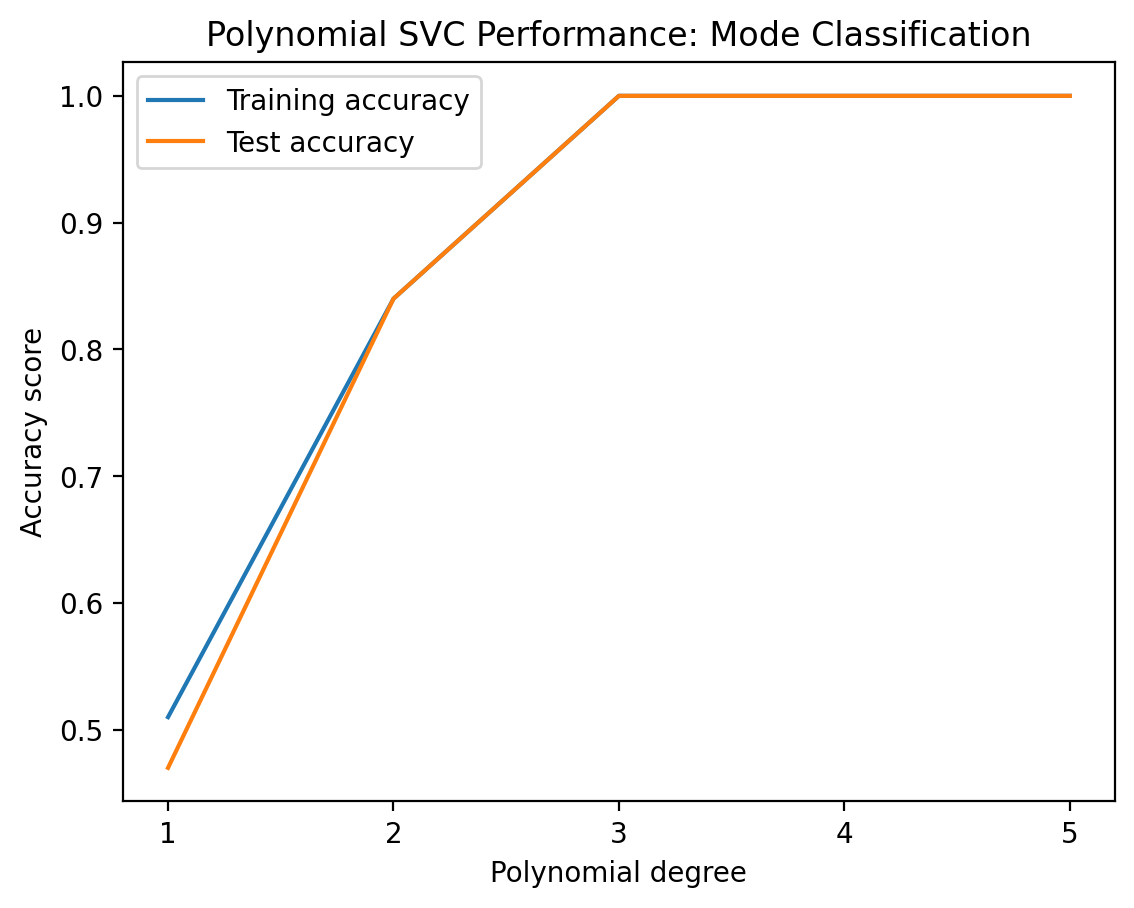

In [24]:
df.loc[[f'SVC Polynomial {n} degree' for n in range(1,6)], 'Mode'].assign(new_index=range(1,6)).set_index('new_index').plot(kind='line', xlabel='Polynomial degree', ylabel='Accuracy score', xticks=range(1,6), title='Polynomial SVC Performance: Mode Classification')
plt.show()

We see here that in order for the SVC to obtain peak performance it requires a polynomial kernel of degree 3. This means that the mode of a piece is effectively a cubic function of the tonal weight $\mathbf{x}^{(n)}$ of a piece.

## Discussion

There are a few different ways to think about the relative complexity of the various classification tasks we've performed. Firstly, note that for dataset A even the linear models were able to determine the mode almost perfectly, and from this we concluded that the data is indeed modally "polarized" in the high-dimensional space as it seems from the t-SNE embedding. Also recall that transposition is equivalent to rotation in the 12-dimensional feature space. By transposing dataset A to all keys we have therefore made 12 copies of these polarized blobs, and then rotated them all relative to each other. While each individual blob is modally polarized along a given direction, the modal "dipoles" of the 12 rotated blobs in dataset B are oriented such that they all cancel out. Thus the overall dataset is modally unpolarized, which is why linear classifiers fail at mode prediction on this dataset.

The reason that linear models succeed at key prediction on dataset B while they fail at mode prediction on the same data is because the key classification task allows the model more flexibility than mode classification. For example, key classification allows the model to treat $A$ minor and $C$ minor as completely separate categories that have nothing to do with each other, while mode classification requires the model to associate these two groups which appear in very different regions of feature space. Thus, the mode classification problem encumbers linear models moreso than key classification, and since they do not have enough complexity to meet the more stringent requirements for this task they fail.

Another important consideration regarding the failure of linear models for mode classification is the effect of our feature engineering scheme, specifically the transposition procedure. The rotational symmetry of dataset B imposes a condition that each individual pitch class is empirically uncorrelated with mode, meaning that for very fundamental symmetry reasons a linear model cannot do better than a coin toss at mode classification on this dataset (in practice when cross-validating and testing we do a random train-validation-test split, which does in principle slightly break this symmetry). Thus our feature engineering procedure defeated the mode prediction task for linear models. Remember that we justified this procedure by stating that the key signature of a hymn is arbitrary. Therefore, as long as this assumption holds we can say that for fundamental reasons of symmetry a linear model cannot predict the mode of a piece if its key signature was determined arbitrarily.

We should note that the failure of linear models at mode classification is not a general statement of the limitation of this class of models for this task, but rather a specific consequence of the features we developed from the raw data (i.e., the total musical content in the MIDI files). Our feature vectors $\mathbf{x}^{(n)}$ tell us how often a given pitch shows up in a piece, but it tells us nothing about the context in which the pitch appears. If we instead engineered higher-order features, such as pair-wise correlations of pitches as they appear together throughout the piece, it is possible that a linear model might be able to perform well on mode classification.

Finally, we can think of mode classification from a musical perspective. Most humans do not have so-called "perfect pitch", meaning that they are unable to absolutely determine the key of a piece that they are listening to. However, despite this, humans who are familiar with music are able to determine whether a piece is in the major or minor mode. The reason for this is that when interpreting music the human mind makes a *relative* comparison of the pitches that it is hearing, and from this comparison it is able to determine the mode. This relative comparison translates to *interactions* between the different pitches in a machine learning context, which in turn corresponds to nonlinear feature mappings. Thus, the intrinscially nonlinear nature of mode classification on dataset B qualitatively resembles the latent nonlinear mapping that people actually do when listening to a piece and determining its mode.